# Mixed-integer programming model to solve the two-sided partial destructive disassembly line balancing problem

The main concept and model are derived from the paper: *"Exploring Engineering Applications of Two-Sided Partial Destructive Disassembly Line Balancing Problem under Electrical Limiting and Time-of-Use Pricing"* by Lei Guo, Zeqiang Zhang, Yu Zhang, Yan Li, and Haolin Song. For a detailed description of the problem, including its parameters and constraints, please refer to their paper, particularly Section 4.2.

To enhance applicability, some modifications have been introduced to the model. These include the addition of a new set of constraints, which are detailed in the **"Constraints Extra"** section.

 

In [1]:
!pip install gurobipy
!pip install numpy
!pip install matplotlib
!pip install networkx

In [2]:
from gurobipy import Model, GurobiError, GRB, LinExpr, Column, quicksum
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

## Parameter Generation

First, I need to generate the parameters for the model. You should only run one of the parameter generation blocks below; running both will result in overwriting.

The first block replicates the setup in the paper, while the second block allows for random parameter generation so you can experiment with the model.



### Replicating the Paper

In this block, I strictly follow the setup, notations, and order presented in Table 2 of the aforementioned paper. You can modify the parameters as needed, such as adding more tasks or stations. However, you must manually adjust the matrix **A** to correctly reflect the dependency of the tasks (currently set to match Figure 4 in the paper), as well as vectors **h** and **e**, which should have a length of **n**. 

The number of sides for the disassembly line is fixed and hard-coded to 2.

*Note*: One error in the paper is that they presented $w_i$ as a parameter, but it should instead be treated as a variable.

In [3]:
import numpy as np
np.random.seed(123)
n = 10# number of tasks
m = 10 # number of possible mated station, set it to equal the number of tasks
e = np.array([i/n for i in range(n)])#vector of length n recording destructive disassembly feasibility value for tasks
# This will be something like, a 
CT = 60 # maximum unit allowed for cycle time
print("Destructive disassembly feasibility values are: ", e)
e_max = 0.7 # Destructive disassembly feasibility threshold. e[i] > e_max implies that task i needs to be destructive 
t1 = np.round(np.random.uniform(10, 40, n), 0) # Vector of time cost for tasks when destructive
print("Vector of time cost for tasks when destructive: ", t1)
t0 = np.round(np.random.uniform(10, 40, n), 0) # Vector of time cost for tasks when non-destructive
print("Vector of time cost for tasks when non-destructive: ", t0)
G1 = np.round(np.random.uniform(50, 75, n), 0) # vector of Disassembly benefits when destructive is used
print("Vector of Disassembly benefits when destructive is used: ", G1)
G0 = np.round(np.random.uniform(60, 85, n), 0) # vector of Disassembly benefits when non-destructive is used
print("Vector of Disassembly benefits when non-destructive is used: ", G0)
E1 = np.round(np.random.uniform(1, 30, (n, 1)), 0) + np.array([0, 10, 20]) # E1[i,s]: Electricity cost per unit of time to process the job when task i uses destructive disassembly in the sth scenario(off, mid, or on peak).
print("E1[i,s]: Electricity cost per unit of time when destructive: \n", E1)
E0 = np.round(np.random.uniform(1, 30, (n, 1)), 0) + np.array([0, 10, 20]) # E0[i,s]: Electricity cost per unit of time to process the job when task i uses non-destructive in the sth scenario.
print("E0[i,s]: Electricity cost per unit of time when non destructive: \n", E0)
E = np.array([i+1 for i in range(m)]) # E[k] is the fixed cost of station k
P1 = np.array([E1[i,0]*1.2 for i in range(n)]) # P1[i] is the power cost of task i per unit of time when destructive
print("P1[i] is the power cost of task i per unit of time when destructive: ", P1)
P0 = np.array([E0[i,0]*1.2 for i in range(n)]) # P0[i] is the power cost of task i per unit of time when non-destructive
print("P0[i] is the power cost of task i per unit of time when non-destructive: ", P0)
p_f = 5 # Fix time unit power comsumption per station
p_h = 5 # Fix time unit power comsumption by Hazardous task per station
A = np.zeros((n, n)) # A relation ship matrix
A[0, 1] = 1; A[0, 2] = 1; A[3,7] = 1; A[4,6] = 1; A[5,6] = 1; A[6,7] = 1; A[7,1] = 1; A[7,2] =1; A[8, 1] = 1; A[8,2] = 1; A[9,1] = 1; A[9,2]= 1
print("Matrix A: \n", A)
h = np.array([1,0,0,1,0,0,0,0,0,0])# h[i] =1 iff task i is a Hazardous task
print("Matrix h: \n", h)
d = np.array([0,1,0,1,0,0,0,0,0,0])# d[i] =1 iff task i is a demand task
print("Matrix d: \n", d)
M = 1000 # This is just a huge number used to write constraints. Change accordingly based on the scale of your parameters and variables
# w_i should be variables, the paper is wrong.

Destructive disassembly feasibility values are:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Vector of time cost for tasks when destructive:  [31. 19. 17. 27. 32. 23. 39. 31. 24. 22.]
Vector of time cost for tasks when non-destructive:  [20. 32. 23. 12. 22. 32. 15. 15. 26. 26.]
Vector of Disassembly benefits when destructive is used:  [66. 71. 68. 65. 68. 58. 59. 56. 57. 66.]
Vector of Disassembly benefits when non-destructive is used:  [62. 71. 71. 72. 71. 68. 71. 82. 84. 73.]
E1[i,s]: Electricity cost per unit of time when destructive: 
 [[19. 29. 39.]
 [ 4. 14. 24.]
 [10. 20. 30.]
 [13. 23. 33.]
 [26. 36. 46.]
 [ 8. 18. 28.]
 [15. 25. 35.]
 [30. 40. 50.]
 [16. 26. 36.]
 [19. 29. 39.]]
E0[i,s]: Electricity cost per unit of time when non destructive: 
 [[ 4. 14. 24.]
 [25. 35. 45.]
 [18. 28. 38.]
 [17. 27. 37.]
 [11. 21. 31.]
 [10. 20. 30.]
 [13. 23. 33.]
 [21. 31. 41.]
 [26. 36. 46.]
 [16. 26. 36.]]
P1[i] is the power cost of task i per unit of time when destructive:  [22.8  4.8 12.  1

Task relationship graph, same as figure 4 in the paper, is drawn bellow:

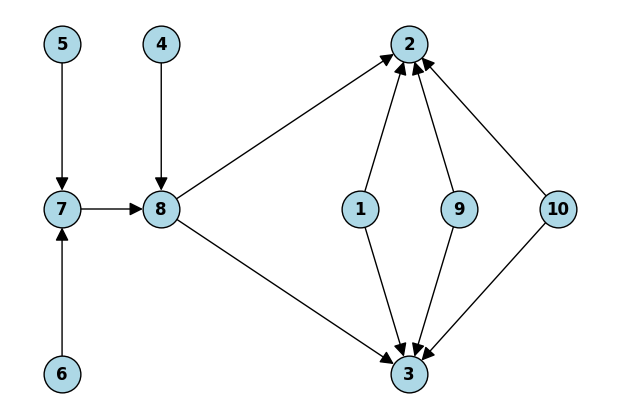

In [4]:
from Utilities import draw_task_precedence_graph
draw_task_precedence_graph()

### Generate random cases

If instead, you wish to generate random cases, then, run this code:

In [5]:
from Utilities import generate_random_dag
import numpy as np
np.random.seed(123)

In [6]:

###################################
#### Parameters you can change ####
###################################
n = 18# number of tasks
m = n # number of possible mated station, set it to equal the number of tasks
e = np.array([i/n for i in range(n)])#vector of length n recording destructive disassembly feasibility value for tasks
# This will be something like, a 
CT = 90 # maximum unit allowed for cycle time
print("Destructive disassembly feasibility values are: ", e)
e_max = 0.7 # Destructive disassembly feasibility threshold. e[i] > e_max implies that task i needs to be destructive 
variance = CT**2 / 100 # For randomness
###########################
#### Random generation ####
###########################

t1 = np.round(np.random.normal(CT / 3, np.sqrt(variance), 2 * n)[(lambda x: (x >= 0.05 * CT) & (x <= 0.7 * CT))(np.random.normal(CT / 2, np.sqrt(variance), 2 * n))][:n], 1) # Vector of time cost for tasks when destructive
print("Vector of time cost for tasks when destructive: ", t1)
t0 = np.round(np.random.normal(CT / 3, np.sqrt(variance), 2 * n)[(lambda x: (x >= 0.05 * CT) & (x <= 0.7 * CT))(np.random.normal(CT / 2, np.sqrt(variance), 2 * n))][:n], 1) # Vector of time cost for tasks when non-destructive
print("Vector of time cost for tasks when non-destructive: ", t0)
G1 = np.round(np.random.normal((CT*1.6) / 2, np.sqrt(variance), 2 * n)[(lambda x: (x >= 0.2 * (CT*1.6)) & (x <= 0.8 * (CT*1.6)))(np.random.normal((CT*1.6) / 2, np.sqrt(variance), 2 * n))][:n], 1) # vector of Disassembly benefits when destructive is used
print("Vector of Disassembly benefits when destructive is used: ", G1)
G0 = np.round(np.random.normal((CT*3) / 2, np.sqrt(variance), 2 * n)[(lambda x: (x >= 0.2 * (CT*3)) & (x <= 0.8 * (CT*3)))(np.random.normal((CT*3) / 2, np.sqrt(variance), 2 * n))][:n], 1) # vector of Disassembly benefits when non-destructive is used
print("Vector of Disassembly benefits when non-destructive is used: ", G0)
E1 = np.round(np.random.uniform(1, 30, (n, 1)), 0) + np.array([0, 10, 20]) # E1[i,s]: Electricity cost per unit of time to process the job when task i uses destructive disassembly in the sth scenario(off, mid, or on peak).
print("E1[i,s]: Electricity cost per unit of time when destructive: \n", E1)
E0 = np.round(np.random.uniform(1, 30, (n, 1)), 0) + np.array([0, 10, 20]) # E0[i,s]: Electricity cost per unit of time to process the job when task i uses non-destructive in the sth scenario.
print("E0[i,s]: Electricity cost per unit of time when non destructive: \n", E0)
E = np.array([(i+1)*CT/10 for i in range(m)]) # E[k] is the fixed cost of station k
P1 = np.array([E1[i,0]*1.2 + CT/5 for i in range(n)]) # P1[i] is the power cost of task i per unit of time when destructive
print("P1[i] is the power cost of task i per unit of time when destructive: ", P1)
P0 = np.array([E0[i,0]*1.2  + CT/5 for i in range(n)]) # P0[i] is the power cost of task i per unit of time when non-destructive
print("P0[i] is the power cost of task i per unit of time when non-destructive: ", P0)
p_f = 8 # Fix time unit power comsumption per station
p_h = 10 # Fix time unit power comsumption by Hazardous task per station
A = generate_random_dag(n)
A = nx.to_numpy_array(A, nodelist=sorted(A.nodes()), dtype=int)
print("Matrix A: \n", A)
h = np.zeros(n)# h[i] =1 iff task i is a Hazardous task
print("Matrix h: \n", h)
d = np.zeros(n)# d[i] =1 iff task i is a demand task
print("Matrix d: \n", d)
M = CT*m+1 # This is just a huge number used to write constraints. Change accordingly based on the scale of your parameters and variables
# w_i should be variables, the paper is wrong.


Destructive disassembly feasibility values are:  [0.         0.05555556 0.11111111 0.16666667 0.22222222 0.27777778
 0.33333333 0.38888889 0.44444444 0.5        0.55555556 0.61111111
 0.66666667 0.72222222 0.77777778 0.83333333 0.88888889 0.94444444]
Vector of time cost for tasks when destructive:  [20.2 39.  32.5 16.4 24.8 44.9  8.2 26.1 41.4 22.2 29.1 43.4 26.  26.1
 49.9 49.7 39.  33.5]
Vector of time cost for tasks when non-destructive:  [40.5 20.1 10.9 39.4 26.4 28.9 22.5 15.5 41.3 23.8 44.9 37.3 27.2 20.2
 23.4 19.1 48.8 31.5]
Vector of Disassembly benefits when destructive is used:  [77.  70.1 76.1 85.9 69.8 73.3 74.3 74.6 59.3 55.1 62.8 73.5 77.  67.2
 84.4 70.7 72.2 70.3]
Vector of Disassembly benefits when non-destructive is used:  [143.1 138.3 128.1 135.  123.7 130.  132.8 131.7 143.6 122.2 127.2 122.6
 123.9 136.1 120.6 141.8 132.8 135.6]
E1[i,s]: Electricity cost per unit of time when destructive: 
 [[17. 27. 37.]
 [ 7. 17. 27.]
 [21. 31. 41.]
 [ 7. 17. 27.]
 [ 9. 19. 29.]

## Variable Initialization

Now, we can begin adding variables. For variables with a superscript index, the superscript is placed at the end of the subscript indexes.



In [7]:
# Initialize Gurobi model

model: Model = Model()

##############################################
##############################################

x = np.zeros((n, m, 2), dtype=object) # x[i,k, l] = 1 if task i is assigned to station k at side l
for l in range(2):
    for i in range(n):
        for k in range(m):
            x[i,k,l] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}{k}{l}")
            
R = np.zeros((n,2), dtype=object) # R[i,r] = 1 if task i adapts disassemble method r, and r is 1 or 2, mapped to index 0 and 1
for r in range(2):
    for i in range(n):
        R[i, r] = model.addVar(vtype=GRB.BINARY, name=f"R_{i}{r}")
        
S = np.zeros(m, dtype=object) # S[k] = 1 iff station k is open
for k in range(m):
    S[k] = model.addVar(vtype=GRB.BINARY, name=f"S_{k}")
    
z = np.zeros((n,n,m,2), dtype=object) #z[i,j,k,l] = 1 iff task i and j are assgined to station k at the side l and i occurs before j 
for i in range(n):
    for j in range(n):
        for k in range(m):
            for l in range(2):
                z[i,j,k,l] = model.addVar(vtype=GRB.BINARY, name=f"z_{i}{j}{k}{l}")
                
t = np.zeros(n, dtype=object) # t[i] is the Disassembly time of the task i
for i in range(n):
    t[i] = model.addVar(lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name=f"t_{i}")
    
G = np.zeros(n, dtype=object) # G[i] is the Disassembly benefits of the task i.
for i in range(n):
    G[i] = model.addVar(lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name=f"G_{i}")
    
E = np.zeros(n, dtype=object)# E[i] is the Electricity cost per unit of disassembly time of task i.
for i in range(n):
    E[i] = model.addVar(lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name=f"E_{i}")

P = np.zeros(n, dtype=object) # P[i] is the Power consumption per unit of disassembly time of task i.
for i in range(n):
    P[i] = model.addVar(lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name=f"P_{i}") 
    
w = np.zeros(n,dtype=object) # w[i]: Start time of task i
for i in range(n):
    w[i] = model.addVar(lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name=f"w_{i}")
    
    
model.update()
print("All variables added, I have now ", model.NumBinVars, "binary variables and ", model.NumVars - model.NumBinVars, "Continuous vars" )

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2508371
Academic license 2508371 - for non-commercial use only - registered to yu___@bse.eu
All variables added, I have now  12366 binary variables and  90 Continuous vars


## Add Groups of Constraints

Next, we add constraints. The constraints are organized into groups as presented in the paper, and I will follow the order and indexing provided there. In total, there are 6 groups of constraints.


### Constraint (1): The Assignment Constraints for the Disassembly Tasks

The meaning of the subsets $D^1$ and $D^2$ is not explicitly clarified in the paper. However, we can deduce that if $i \in D^2$, then task $i$ can only be assigned to the right side of the disassembly line. 

For simplicity, we define $D^1$ to include indices 0 to 4 and $D^2$ to include indices 5 to 9. This simplifies the implementation.



In [8]:
# Eq. (6) means every task is assigned to station
for i in range(n):
    model.addConstr(quicksum(x[i,k,l]
                             for k in range(m)
                             for l in range(2)
                             )==1, name=f"Equation6{i}")

# Eq. (7)- Eq. (8) indicate that the task needs to satisfy the disassembly direction constraint.
for i in range(5):
    model.addConstr(quicksum(x[i,k,0]
                             for k in range(m)
                             )==1, name=f"Equation7{i}")
for i in range(5, 10):
    model.addConstr(quicksum(x[i,k,1]
                             for k in range(m)
                             )==1, name=f"Equation8{i}")

# Print summary
model.update()
print(f"Number of constraints: {model.getAttr('NumConstrs')}")

Number of constraints: 28


### Constraint (2): The Disassembly Mode Constraints

- Equation 10 is not linear; I have transformed it into a linear form: $e_i R_i^1 < e_{max} \quad \forall i \in N$
- Equation 11 duplicates Equation 9, so it has been removed.
- Equations 12-13 are also not linear and need to be transformed:
  $$
  (1 - R_i^2)M \geq h_i + d_i \quad \forall i \in N
  $$


In [9]:
# Eq. (9) denotes that only one disassembly mode can be selected for each task.
for i in range(n):
    model.addConstr(quicksum(R[i,r]
                             for r in range(2)
                             )==1, name=f"Equation9{i}")

#Eq. (10) is transformed to linear version
for i in range(n):
    model.addConstr(e[i]*R[i,0] <= e_max, name=f"Equation10{i}")

#Eq 12-13 are also transformed
for i in range(n):
    model.addConstr((1-R[i,1])*M >= h[i]+d[i], name=f"Equation12_13{i}")

# Print summary
model.update()
print(f"Number of constraints: {model.getAttr('NumConstrs')}")

Number of constraints: 82


### Constraint (3): Relationship Between Disassembly Time ($t_i$), Disassembly Benefit ($G_i$), Electricity Cost ($E_{is}$), and Disassembly Mode ($R_i$)

This constraint establishes a relationship between the disassembly time, benefit, and electricity cost for each task based on the disassembly mode used.


In [10]:
for i in range(n):
    model.addConstr(t[i] == R[i,0]*t0[i] + (1 - R[i,0])*t1[i], name=f"Equation15{i}")
    model.addConstr(G[i] == R[i,0]*G0[i] + (1 - R[i,0])*G1[i], name=f"Equation16{i}")
    model.addConstr(E[i] == R[i,0]*E0[i,2] + (1 - R[i,0])*E1[i,2], name=f"Equation17{i}")
    model.addConstr(P[i] == R[i,0]*P0[i] + (1 - R[i,0])*P1[i], name=f"Equation18{i}")

# Print summary
model.update()
print(f"Number of constraints: {model.getAttr('NumConstrs')}")

Number of constraints: 154


### Constraint (4): Stations related constraints.

In [11]:
# Eq. (19) describes the number of stations.
model.addConstr(quicksum(S[k] for k in range(m))>=quicksum(t[i] for i in range(n))/(2*CT), name = "Equation19")

#Eq. (20)- Eq. (21) shows that the station has to be open when assigning a disassembly task to the station,
for k in range(m):
    model.addConstr(S[k] <= quicksum(x[i,k,l]
                                     for i in range(n)
                                     for l in range(2)),
                    name = f"Equation20{k}")
    model.addConstr(n*S[k] >= quicksum(x[i,k,l]
                                     for i in range(n)
                                     for l in range(2)),
                    name = f"Equation21{k}")
# Eq. (22)  restricts the number of stations that must be turned on sequentially.
for k in range(m-1):
    model.addConstr(S[k]>=S[k+1], name=f"Equation22{k}")

# Print summary
model.update()
print(f"Number of constraints: {model.getAttr('NumConstrs')}")
    

Number of constraints: 208


### Constraint (5): Location-related constraints.


In [12]:
#Eq. (23) indicates that if tasks i and j are assigned to the same station, they must occupy the same side of that station.
for i in range(n):
    for j in range(i+1,n):
        for l in range(2):
            for k in range(m):
                model.addConstr(x[i,k,l] + x[j,k,l] <= 1+z[i,j,k,l] + z[j,i,k,l], name = f"Equation23{i}{j}{l}{k}")

# Eq. (24) indicates that if tasks i and j are assigned to the same side of a station, they cannot be on different stations:
for i in range(n):
    for j in range(i+1,n):
        for l in range(2):
            for k in range(m):
                model.addConstr((x[i,k,l] + x[j,k,l])/2 >= z[i,j,k,l] + z[j,i,k,l], name = f"Equation24{i}{j}{l}{k}")

# Print summary
model.update()
print(f"Number of constraints: {model.getAttr('NumConstrs')}")


Number of constraints: 11224


### Constraint (6): Time-Related Constraints

- Equation (25), the non-negative constraint, is already accounted for when adding the variables.
- Equation (29) contains an error in the paper; it should be $A_{ji} = 1$.


In [13]:
# Eq. (26) indicates that Any task assigned to the back of another task must wait for the completion of the preceding task before starting its disassembly
for i in range(n):
    model.addConstr(
        w[i] >= CT * (
                quicksum(x[i, k, l]*(k+1) for k in range(m) for l in range(2)) - 1 # Number of previous stations times cycle time
        ) + quicksum(
            z[j,i, k, l] for k in range(m) for l in range(2) for j in range(n) if j != i # Summed time of tasks tthat comes before i in the same station
        ),
        name=f"Equation26{i}"
    )
    
# Eq. (27) indicates that if two tasks i and j are assigned to the same station, and task j is ahead of task i, then task i must wait for task j to finish before starting;
for i in range(n):
    for j in range(n):
        if i != j:
            for l in range(2):
                for k in range(m):
                    model.addConstr(M*(1-z[j,i,k,l]) + w[i] >= w[j] + t[j], name = f"Equation27{i}{j}{l}{k}")
                
# Eq. (28) indicates that task must complete its disassembly within the beat time allocated for its station;
# This one was initially causing problems, because the index starts from 0 in programming, but 1 in python. So, need to time k+1, not k
for i in range(n):
    model.addConstr(w[i] + t[i] <= quicksum(x[i,k,l]*(k+1) for k in range(m) for l in range(2)) * CT, name = f"Equation28{i}")
    
# Eq. (29) indicates that task i must wait for its immediately preceding task j to finish disassembly before it can start, even if they are on different sides of the same station.
for i in range(n):
    for j in range(n):
        if A[j, i] == 1:   
            model.addConstr(w[i] >= w[j] + t[j], name = f"Equation29{i}{j}")

# Print summary
model.update()
print(f"Number of constraints: {model.getAttr('NumConstrs')}")

Number of constraints: 22296


### Constraint Extra: Carry Time Constraints

This is a constraint I introduced, assuming that between different workstations, goods must be carried from one station to another. Thus, a fixed time cost $T_{\text{carry}}$ is required before workstation $k$ can begin operating. This can be expressed as follows:

$$
T_{\text{carry}} \geq \min\{w_i \mid x_{i,k+1}^l = 1\} - \max\{w_i + t_i \mid x_{ik}^l = 1\}, \quad \forall i \in N, \, k \in M, \, l \in L
$$

This expression is clearly not linear, so we introduce two auxiliary variables, $w_k^{\text{max}}$ and $w_k^{\text{min}}$, which respectively record the maximum ending time and minimum starting time of station $k$. To enforce this, we impose the following group of constraints:

$$
w_k^{\text{max}} \geq (w_i + t_i) - \big(1 - \sum_{l \in L} x_{ik}^l\big)M, \quad \forall k \in M, \, i \in N
$$
$$
w_k^{\text{min}} \leq w_i + \big(1 - \sum_{l \in L} x_{ik}^l\big)M, \quad \forall k \in M, \, i \in N
$$
$$
T_{\text{carry}} \leq w_k^{\text{min}} - w_{k-1}^{\text{max}}, \quad \forall k \in M \setminus \{1\}
$$

Be absolutely careful that $\max\{t_i^0, t_i^1\} < CT - T_{\text{carry}}$ must hold for all $i \in N$ when the problem is generated; otherwise, the problem may become infeasible from the first iteration!


In [14]:
T_c = 10## the minimum carry time
# Add the auxiliary variables:
wmax = np.zeros(m, dtype=object)
wmin = np.zeros(m, dtype=object)
for k in range(m):
    wmax[k] = model.addVar(lb=0,ub = GRB.INFINITY , vtype=GRB.CONTINUOUS, name=f"wmax{k}")
    wmin[k] = model.addVar(lb=0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name=f"wmin{k}")

for k in range(m):
    for i in range(n):
        model.addConstr(wmax[k] >= w[i]+t[i] - M*(1-quicksum(x[i,k,l] for l in range(2))), name=f"Extra1{k}{i}")
        model.addConstr(wmin[k] <= w[i] + M*(1-quicksum(x[i,k,l] for l in range(2))), name=f"Extra2{k}{i}")

for k in range(1,m):
    model.addConstr(T_c <= wmin[k]-wmax[k-1], name=f"Extra3{k}")

## Optimization

Now that all constraints have been added, we can proceed to optimize the model. In the paper, they considered 4 different objective values, making this a multi-objective programming problem. However, instead of computing the Pareto front—which is complex—let's test the model's results by optimizing each objective individually as a single objective function.



### Minimize the Number of Stations Opened

First, consider $f_1$, which represents the number of stations opened.

In [15]:
f1 = quicksum(S[i] for i in range(n))
model.setObjective(f1, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2508371 - for non-commercial use only - registered to yu___@bse.eu
Optimize a model with 22961 rows, 12492 columns and 105947 nonzeros
Model fingerprint: 0xb1f6c35e
Variable types: 126 continuous, 12366 integer (12366 binary)
Coefficient statistics:
  Matrix range     [6e-03, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+03]
Presolve removed 14136 rows and 8155 columns
Presolve time: 1.32s
Presolved: 8825 rows, 4337 columns, 35893 nonzeros
Variable types: 35 continuous, 4302 integer (4302 binary)

Root relaxation: objective 3.000000e+00, 399 iterations, 0.02 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

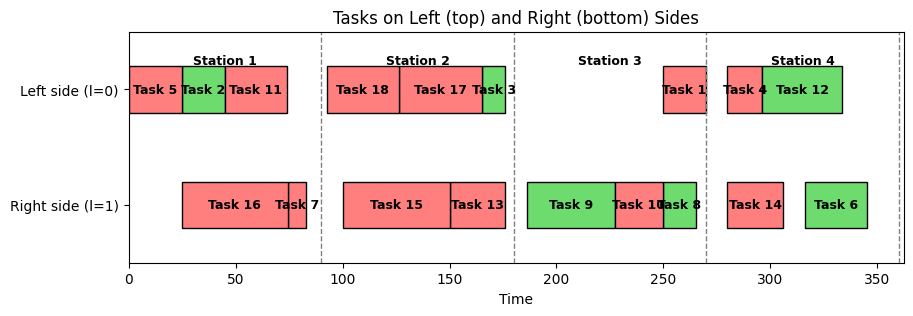

In [16]:
from Utilities import plot_result
plot_result(n,m,w,t,x,R,CT)

### Minimize Idle Time of the Stations

Next, consider $f_2$, which represents the idle time of the stations. Minimizing this objective ensures a more efficient disassembly line.


In [17]:
f2 = quicksum((2*S[k]*CT -quicksum(x[i,k,l]*t[i] for i in range(n) for l in range(2))) for k in range(m))
model.setObjective(f2, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2508371 - for non-commercial use only - registered to yu___@bse.eu
Optimize a model with 22961 rows, 12492 columns and 105947 nonzeros
Model fingerprint: 0xe9663baa
Model has 648 quadratic objective terms
Variable types: 126 continuous, 12366 integer (12366 binary)
Coefficient statistics:
  Matrix range     [6e-03, 2e+03]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+03]

MIP start from previous solve produced solution with objective 220.9 (0.02s)
Loaded MIP start from previous solve with objective 220.9

Presolve removed 14037 rows and 8142 columns
Presolve time: 1.42s
Presolved: 9179 rows, 4605 columns, 39612 nonzeros
Variable types: 35 contin

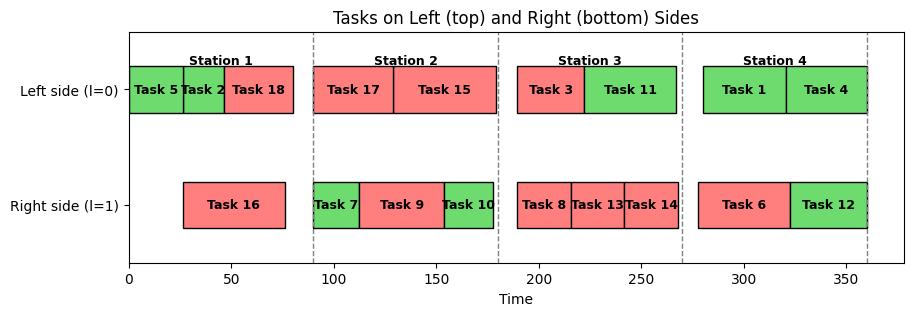

In [18]:
plot_result(n,m,w,t,x,R,CT)

### Maximize the Disassembly Profit

Now, consider $f_3$, which represents the disassembly profit. Naturally, we want to maximize this, so we include a "-" before it to convert it into a minimization problem.

The original objective function is not linear because it contains products of variables. However, it can be linearized by introducing auxiliary variables to represent the product of binary variables. The general rule is as follows:

To model the product of two binary variables $x \cdot y$, we introduce an auxiliary binary variable $z = x \cdot y$ and enforce the relationship using the following constraints:

- $z \leq x$ 
- $z \leq y$ 
- $z \geq x + y - 1$

These constraints ensure that $z$ correctly represents the logical AND ($x \cdot y$) of the binary variables $x$ and $y$.

If the product involves more than two binary variables, we can add auxiliary variables recursively to represent the nested products.


In [19]:
# First, set the auxiliary vars, and add the constraints accordingly
y = {}
for i in range(n):
    for k in range(m):
        for l in range(2):
            y[i,k,l] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{k}_{l}")
for i in range(n):
    for k in range(m):
        for l in range(2):
            model.addConstr(y[i,k,l] <= x[i,k,l],    name=f"y_le_x_{i}_{k}_{l}")
            model.addConstr(y[i,k,l] <= R[i,0],      name=f"y_le_R_{i}_{k}_{l}")
            model.addConstr(y[i,k,l] >= x[i,k,l] + R[i,0] - 1,
                            name=f"y_ge_xR_{i}_{k}_{l}")


# Define f3 step by step
term1 = quicksum( # This term is the sum of income of tasks
    G1[i] * x[i,k,l]
    + (G0[i] - G1[i]) * y[i,k,l]
    for i in range(n) for k in range(m) for l in range(2)
)



term2 = quicksum(# This term is the sum of energy cost
    (
            (E1[i,2]*t1[i]) * x[i,k,l]         # A[i] * x
            + (E0[i,2]*t0[i] - E1[i,2]*t1[i]) * y[i,k,l]
    )
    for i in range(n) for k in range(m) for l in range(2)
)



term3 = quicksum(# This term is the fixed sum for each operation workstation
    S[k]*CT * (
            E1[i,2] + (E0[i,2] - E1[i,2]) * R[i,0]
    )
    for i in range(n) for k in range(m)
)



term4 = quicksum(# This term is the extra cost if a task is hazardous
    h[i] * (
            (E1[i,2]*t1[i]) * x[i,k,l]  # A[i]* x
            + (E0[i,2]*t0[i] - E1[i,2]*t1[i]) * y[i,k,l]
    )
    for i in range(n) for k in range(m) for l in range(2)
)

# Combine all terms into f3
f3 = term1 - term2 - term3 - term4

# Set the objective
f3 = -f3
model.setObjective(f3, GRB.MINIMIZE)

# Optimize the model
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2508371 - for non-commercial use only - registered to yu___@bse.eu
Optimize a model with 24905 rows, 13140 columns and 110483 nonzeros
Model fingerprint: 0xd9482df1
Model has 306 quadratic objective terms
Variable types: 126 continuous, 13014 integer (13014 binary)
Coefficient statistics:
  Matrix range     [6e-03, 2e+03]
  Objective range  [7e+01, 6e+04]
  QObjective range [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+03]

MIP start from previous solve produced solution with objective 267201 (0.02s)
Loaded MIP start from previous solve with objective 267201

Presolve removed 15771 rows and 8630 columns
Presolve time: 1.68s
Presolved: 9179 rows, 4555 columns, 37717 nonzeros
Found heuristic solutio

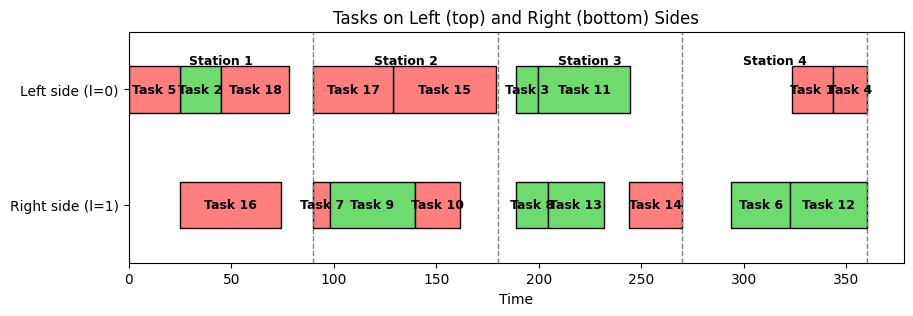

In [20]:
plot_result(n,m,w,t,x,R,CT)

### Minimize Disassembly Energy Consumption

Finally, $f_4$ represents the disassembly energy consumption, which we aim to minimize.


In [21]:

term1 = quicksum( # Energy cost of doing the tasks
    # Affine terms in x[i,k,l]
    x[i,k,l] * (
            t1[i] * (P1[i] + p_h * h[i])  # t1[i] * P_full when R[i,0]=0
            + (t0[i] - t1[i]) * (P1[i] + p_h * h[i])  # When R[i,0]=1
    )
    + y[i,k,l] * (
            (t0[i] - t1[i]) * (P0[i] - P1[i])  # Interaction of R[i,0]
    )
    for i in range(n) for k in range(m) for l in range(2)
)

term2 = quicksum( # Fixed energy cost of openning stations
    p_f * S[k] * CT
    for k in range(m)
)

f4 = term1 + term2

model.setObjective(f4, GRB.MINIMIZE)

# Optimize the model
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2508371 - for non-commercial use only - registered to yu___@bse.eu
Optimize a model with 24905 rows, 13140 columns and 110483 nonzeros
Model fingerprint: 0xeba2d51c
Variable types: 126 continuous, 13014 integer (13014 binary)
Coefficient statistics:
  Matrix range     [6e-03, 2e+03]
  Objective range  [2e-01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+03]

MIP start from previous solve produced solution with objective 23259.1 (0.02s)
Loaded MIP start from previous solve with objective 23259.1

Presolve removed 22308 rows and 11861 columns
Presolve time: 1.14s
Presolved: 2597 rows, 1279 columns, 10624 nonzeros
Variable types: 23 continuous, 1256 integer (1256 binary)

Root relaxation: objective 2.210436

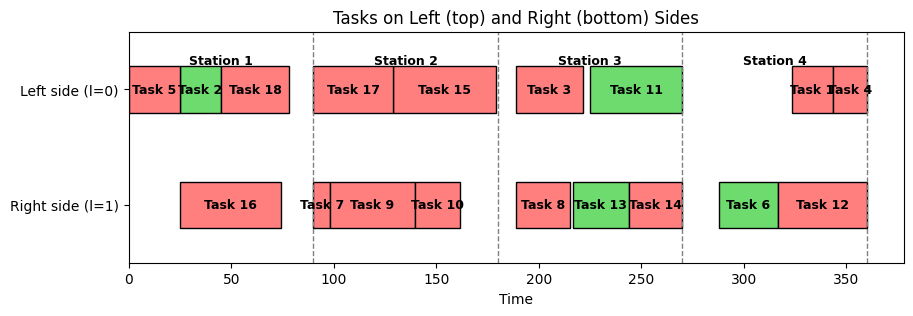

In [22]:
plot_result(n,m,w,t,x,R,CT)